In [1]:
import datetime as dt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import json

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler

datapath = 'static/data/globalsales.csv'

Using TensorFlow backend.


In [7]:
       
def to_json(datapath, year = 2021, output = 'sales'):
    
    cats = ["Furniture", "Office Supplies", "Technology"]
    subcats = [["Bookcases", "Furnishings", "Tables", "Chairs"],["Appliances", "Binders", "Envelopes", "Fasteners", "Labels", "Paper", "Storage", "Supplies", "Art"],["Accessories", "Machines", "Phones", "Copiers"]]
    markets = ["Africa", "Asia Pacific", "Europe", "LATAM", "USCA"]
    regions = [["Central Africa", "Eastern Africa", "North Africa", "Southern Africa", "Western Africa"],["Central Asia", "Eastern Asia", "Oceania", "Southeastern Asia", "Southern Asia", "Western Asia"],["Eastern Europe", "Northern Europe", "Southern Europe", "Western Europe"],["Caribbean", "Central America", "South America"],["Canada", "Central US", "Eastern US", "Southern US", "Western US"]]
    
    
    data =[]
    n1=0
    alls = 'all'
    for cat in cats:
        d={}
        d["cat"] = cat
        d["subcat"] = alls
        d["market"] = alls
        d["region"] = alls
        data.append(d)

        subcat_u = subcats[n1]
        n1 = n1 + 1
        for subcat in subcat_u:
            d={}
            d["cat"] = cat
            d["subcat"] = subcat
            d["market"] = alls
            d["region"] = alls
            data.append(d)
            n2 = 0
            for market in markets:
                d={}
                d["cat"] = cat
                d["subcat"] = subcat
                d["market"] = market
                d["region"] = alls
                data.append(d)
                
                region_u = regions[n2]
                n2 = n2 + 1
                for region in region_u:
                    d ={}
                    d["cat"] = cat
                    d["subcat"] = subcat
                    d["market"] = market
                    d["region"] = region
                    
                    try:
                        d["x"], d["y"] ,d["y_fcst"] ,d["MSE"], d["MAPE"] = return_forecast(datapath, year = year, output = output, cat = cat, subcat = subcat, market = market, region = region)
                    except Exception:
                        pass

                    data.append(d)
    
    return data

In [8]:
cats = ["all","Furniture", "Office Supplies", "Technology"]
subcats = [["all","Bookcases", "Furnishings", "Tables", "Chairs"],["all","Appliances", "Binders", "Envelopes", "Fasteners", "Labels", "Paper", "Storage", "Supplies", "Art"],["all","Accessories", "Machines", "Phones", "Copiers"]]
markets = ["all","Africa", "Asia Pacific", "Europe", "LATAM", "USCA"]
regions = [["all","Central Africa", "Eastern Africa", "North Africa", "Southern Africa", "Western Africa"],["all","Central Asia", "Eastern Asia", "Oceania", "Southeastern Asia", "Southern Asia", "Western Asia"],["all","Eastern Europe", "Northern Europe", "Southern Europe", "Western Europe"],["all","Caribbean", "Central America", "South America"],["all","Canada", "Central US", "Eastern US", "Southern US", "Western US"]]
    
regions[4]

['all', 'Canada', 'Central US', 'Eastern US', 'Southern US', 'Western US']

In [20]:
def filterdata(df1,output='sales', cat = "all", subcat = "all", market = "all", region = "all" ):
    
    if cat != "all":
        df2 = df1[df1['cat']==cat]
    else:
        df2 = df1
    if subcat != "all":
        df3 = df2[df2['subcat']==subcat]
    else:
        df3 = df2
    if market != "all":
        df4 = df3[df3['market']==market]
    else:
        df4 = df3
    if region != "all":
        df5 = df4[df4['region']==region]
    else:
        df5 = df4
                
    df_filtered = df5.groupby(['date'], as_index = False)["{}".format(output)].sum()
    df_filtered = df_filtered.set_index('date').sort_values(by = 'date')

    return df_filtered


def to_integer(dt_time):
    return (dt_time.year-2016)*12 + dt_time.month

def clean_data(datapath, output='sales', cat = "all", subcat = "all", market = "all", region = "all"):
    df = pd.read_csv(datapath,encoding = "ISO-8859-1")
    df.drop(df.columns[[0,1,2,3,5,6,7,8,9,10,11,12,13,16,17,25]], axis=1, inplace=True)
    df.columns =['date',"region","market","subcat","cat","sales","quantity","discount","profit","shippingcost"]
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%m/%d/%Y'))
    df['date'] = df['date'].apply(lambda dt: dt.replace(day=1))
    df_main = df.groupby(['date','region','market','subcat','cat'], as_index = False)['sales','profit','shippingcost'].sum()
    result_df = filterdata(df_main, output=output, cat =cat, subcat =subcat, market =market, region =region)
    return result_df

def forecast_period(year):
    fcst_date = []
    for year in np.arange(2020,year+1):
        for month in np.arange(1,13):
            fcst_date.append(dt.datetime(year,month,1))
    return fcst_date

def return_forecast(datapath, year = 2021, output='sales', cat = "all", subcat = "all", market = "all", region = "all"):

    result_df = clean_data(datapath, output=output, cat =cat, subcat =subcat, market =market, region =region)

    sum_2017 = result_df[result_df.index.year == 2017] .sum()
    sum_2018 = result_df[result_df.index.year == 2018] .sum()
    sum_2019 = result_df[result_df.index.year == 2019] .sum()

    growth_2018 =  sum_2018 / sum_2017
    growth_2019 =  sum_2018 / sum_2017

    Avg_growth = (growth_2018 + growth_2019)/2

    X_forecast = forecast_period(year)

    for row in X_forecast:
        result_df.loc[row] = result_df.iloc[-12] * Avg_growth

    df_diff = result_df.copy()

    df_diff['prev'] = df_diff[output].shift(1)
    df_diff['date'] = df_diff.index
    df_diff['diff'] = (df_diff[output] - df_diff['prev'])

    #create dataframe for transformation from time series to supervised
    df_supervised = df_diff.drop(['prev'],axis=1)
    #adding lags
    for inc in range(1,13):
        field_name = 'lag_' + str(inc)
        df_supervised[field_name] = df_supervised['diff'].shift(inc)

    #drop null values
    df_supervised = df_supervised.dropna().reset_index(drop=True)

    #import MinMaxScaler and create a new dataframe for LSTM model
    df_model = df_supervised.drop([output,'date'],axis=1)

    #split train and test set
    train_set, test_set = df_model[0:-(len(X_forecast)+12)].values, df_model[-(len(X_forecast)+12):].values

    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mape'])
    model.fit(X_train, y_train, nb_epoch=200, batch_size=1, verbose=1, shuffle=False)
    accuracy = model.evaluate(X_test, y_test, batch_size = 1)

    y_pred = model.predict(X_test,batch_size=1)
    #for multistep prediction, you need to replace X_test values with the predictions coming from t-1

    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

    #create dataframe that shows the predicted sales
    result_list = []
    dates = list(result_df[-(len(X_forecast)+13):].index)
    act_value = list(result_df[-(len(X_forecast)+13):][output])

    for index in range(0,len(pred_test_set_inverted)):
        result_dict = {}
        result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_value[index])
        result_dict['date'] = dates[index+1]
        result_list.append(result_dict)
    df_result = pd.DataFrame(result_list)
    #for multistep prediction, replace act_sales with the predicted sales

    #merge with actual sales dataframe
    df_sales_pred = pd.merge(result_df,df_result,on='date',how='left')
    df_sales_pred.iloc[-(len(X_forecast)):,1] = np.nan

    return df_sales_pred['date'], df_sales_pred[output], df_sales_pred['pred_value'], accuracy[0], accuracy[1]


Epoch 1/200
23/23 [==============================] - 1s 23ms/step - loss: 0.2923 - mape: 104.0329
Epoch 2/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2646 - mape: 96.5550
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2515 - mape: 93.3812
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2397 - mape: 90.3174
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2290 - mape: 87.7255
Epoch 6/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2189 - mape: 85.9887
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2093 - mape: 83.9346
Epoch 8/200
23/23 [==============================] - 0s 2ms/step - loss: 0.1999 - mape: 82.2763
Epoch 9/200
23/23 [==============================] - 0s 2ms/step - loss: 0.1906 - mape: 80.8063
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.1814 - mape: 79.8599
Epoch 11/200
23/23 [================

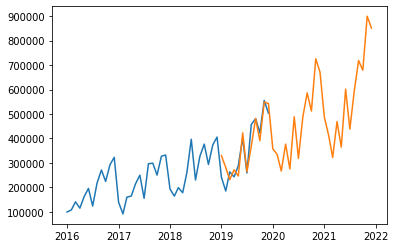

In [21]:
x, y, y_pred, mse, mape = return_forecast(datapath, year = 2021, output='sales', cat = "all", subcat = "all", market = "all", region = "all")
plt.plot(x,y)
plt.plot(x,y_pred)
print('test loss, Mean Absolute Percentage Error(MAPE):', mse, mape)

In [75]:
jsonbject = to_json(datapath)

In [76]:
jsonbject

In [11]:
df = pd.read_csv(datapath,encoding = "ISO-8859-1")
df.drop(df.columns[[0,1,2,3,5,6,7,8,9,10,11,12,13,16,17,25]], axis=1, inplace=True)

In [12]:
df

,orderdate,region,market,subcategory,category,sales,quantity,discount,profit,shippingcost
0,1/1/2016,Northern Europe,Europe,Paper,Office Supplies,44.87,3,0.5,-26.06,4.82
1,1/1/2016,Oceania,Asia Pacific,Supplies,Office Supplies,120.37,3,0.1,36.04,9.72
2,1/1/2016,Oceania,Asia Pacific,Paper,Office Supplies,55.24,2,0.1,15.34,1.80
3,1/1/2016,Oceania,Asia Pacific,Furnishings,Furniture,113.67,5,0.1,37.77,4.70
4,1/1/2016,North Africa,Africa,Storage,Office Supplies,408.30,2,0.0,106.14,35.46
...,...,...,...,...,...,...,...,...,...,...
51285,12/31/2019,Eastern Europe,Europe,Labels,Office Supplies,27.84,4,0.0,6.12,1.70
51286,12/31/2019,North Africa,Africa,Binders,Office Supplies,3.99,1,0.0,0.42,1.49
51287,12/31/2019,Eastern Europe,Europe,Fasteners,Office Supplies,138.24,12,0.0,55.08,8.03
51288,12/31/2019,Eastern Africa,Africa,Labels,Office Supplies,49.50,6,0.0,6.84,2.15


In [17]:
def clean_data(datapath, output='sales', cat = "all", subcat = "all", market = "all", region = "all"):
    df = pd.read_csv(datapath,encoding = "ISO-8859-1")
    df.drop(df.columns[[0,1,2,3,5,6,7,8,9,10,11,12,13,16,17,25]], axis=1, inplace=True)
    df.columns =['date',"region","market","subcat","cat","sales","quantity","discount","profit","shippingcost"]
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%m/%d/%Y'))
    df['date'] = df['date'].apply(lambda dt: dt.replace(day=1))
    df_main = df.groupby(['date','region','market','subcat','cat'], as_index = False)['sales','profit','shippingcost'].sum()
    result_df = filterdata(df_main, output=output, cat =cat, subcat =subcat, market =market, region =region)
    return result_df



In [18]:
df = clean_data(datapath)

In [19]:
df

,sales
date,
2016-01-01,98898.53
2016-02-01,107866.38
2016-03-01,140520.20
2016-04-01,114686.16
2016-05-01,161469.70
2016-06-01,195443.97
2016-07-01,123390.44
2016-08-01,217082.95
2016-09-01,270821.83
